# Part 2: Solving a simple boundary integral equation.

1. Use higher quadrature order than basis order via interpolating the density to a finer grid.
2. Nearest neighbors, use each QBX when needed.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# the n-point gauss quadrature rule on [-1, 1], returns tuple of (points, weights)
def gauss_rule(n):
    k = np.arange(1.0, n)
    a_band = np.zeros((2, n))
    a_band[1, 0:(n - 1)] = k / np.sqrt(4 * k * k - 1)
    x, V = scipy.linalg.eig_banded(a_band, lower=True)
    w = 2 * np.real(np.power(V[0, :], 2))
    return x, w

# the n-point trapezoidal rule on [-1, 1], returns tuple of (points, weights)
def trapezoidal_rule(n):
    return np.linspace(-1.0, 1.0, n + 1)[:-1], np.full(n, 2.0 / n)

# archetype of a simple curve function, returns  (x, y, nx, ny, jacobian)
# here the jacobian of the transformation is constant and equal to pi.
def circle(quad_pts):
    theta = np.pi * (quad_pts + 1)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y, x, y, np.pi

In [2]:
# TODO: MOVE quad_rule to position 2 in the list
def double_layer_matrix(surface, obsx, obsy, quad_rule):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface
    
    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2

    # double layer potential
    integrand = -1.0 / (2 * np.pi) * (dx * srcnx[None, :] + dy * srcny[None, :]) / r2
    
    return integrand * curve_jacobian * quad_rule[1][None, :]

The double layer potential self-interaction can actually be computed directly without singular integration via some clever mathematical tricks. However, we're going to ignore that fact for now because it's not true  in the general case with the various elasticity kernels.

In [11]:
def qbx_expand_matrix(surface, quad_rule, qbx_p = 5, mult = 5.0, direction = 1.0):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface

    qbx_nq = 2 * qbx_p + 1
    qbx_qx, qbx_qw = trapezoidal_rule(qbx_nq)
    qbx_qw *= np.pi
    qbx_theta = np.pi * (qbx_qx + 1)

    quad_pt_spacing = curve_jacobian * quad_rule[1]
    qbx_r = mult * quad_pt_spacing
    qbx_eval_r = qbx_r * 0.5
    center_x = srcx + direction * qbx_r * srcnx
    center_y = srcy + direction * qbx_r * srcny

    qbx_x = center_x[:, None] + qbx_eval_r[:, None] * np.cos(qbx_theta)[None, :]
    qbx_y = center_y[:, None] + qbx_eval_r[:, None] * np.sin(qbx_theta)[None, :]
    
    qbx_u_matrix = double_layer_matrix(surface, qbx_x.flatten(), qbx_y.flatten(), quad_rule).reshape((*qbx_x.shape, srcx.shape[0]))

    alpha = np.empty((srcx.shape[0], qbx_p, srcx.shape[0]), dtype=np.complex)
    for L in range(qbx_p):
        C = 1.0 / (np.pi * (qbx_eval_r ** L))
        if L == 0:
            C /= 2.0
        oscillatory = qbx_qw[None,:,None] * np.exp(-1j * L * qbx_theta)[None,:,None]
        alpha[:, L, :] = C * np.sum(qbx_u_matrix * oscillatory, axis=1)
    return alpha, center_x, center_y, qbx_r

def qbx_eval_matrix(obsx, obsy, center_x, center_y, qbx_p = 5):
    obs_complex = obsx + obsy * 1j
    qbx_center = center_x + center_y * 1j
    sep = obs_complex - qbx_center[None, :]
    out = np.empty((obsx.shape[0], obsx.shape[1], qbx_p), dtype=np.complex)
    for L in range(qbx_p):
        out[:, :, L] = sep ** L
    return out

from scipy.spatial import cKDTree
def qbx_interior_eval(surface, quad_rule, density, obsx, obsy, qbx_center_x, qbx_center_y, qbx_coeffs):
    center_pts = np.array([qbx_center_x, qbx_center_y]).T
    qbx_centers_tree = cKDTree(center_pts)
    
    surface_pts = np.array([surface[0], surface[1]]).T
    surface_tree = cKDTree(surface_pts)

    lookup_pts = np.array([obsx.flatten(), obsy.flatten()]).T
    dist_to_expansion, closest_expansion = qbx_centers_tree.query(lookup_pts)
    dist_to_surface, closest_surface = surface_tree.query(lookup_pts)

    use_qbx = (dist_to_expansion < qbx_r[closest_expansion]) & (dist_to_surface < qbx_r[closest_expansion])
    qbx_centers_used, inverse_idxs, center_counts = np.unique(closest_expansion[use_qbx], return_inverse=True, return_counts=True)
    
    most_per_qbx_center = np.max(center_counts)
    qbx_eval_pts = np.zeros((most_per_qbx_center, qbx_centers_used.shape[0], 2))
    orig_pt_idxs = np.full((most_per_qbx_center, qbx_centers_used.shape[0]), np.nan, dtype=np.int)
    for i, c, in enumerate(qbx_centers_used):
        I = np.where((closest_expansion == c) & use_qbx)[0]
        orig_pt_idxs[:I.shape[0], i] = I
        qbx_eval_pts[:I.shape[0], i] = lookup_pts[orig_pt_idxs[:I.shape[0], i], :]
        
    out = double_layer_matrix(
        surface   = surface,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule
    ).dot(density)
    
    Q = qbx_eval_matrix(qbx_eval_pts[:,:,0], qbx_eval_pts[:,:,1], qbx_center_x[qbx_centers_used], qbx_center_y[qbx_centers_used], qbx_p = qbx_p)
    
    out_for_qbx_points = np.sum(Q * qbx_coeffs[qbx_centers_used][None,:,:], axis=2)
    out[orig_pt_idxs[orig_pt_idxs > 0]] = out_for_qbx_points[orig_pt_idxs > 0]
    
    return out.reshape(obsx.shape)

In [34]:
n = 200
quad_rule = trapezoidal_rule(n)
surface = circle(quad_rule[0])

In [84]:
nobs = 400

zoomx = [-2, 2]
zoomy = [-2, 2]
zoomx = [0.75, 1.25]
zoomy = [0.15, 0.65]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

In [85]:
bie_eval = double_layer_matrix(
    surface   = surface,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = quad_rule
).dot(surface[1]).reshape(obsx.shape)

quad_rule_high = trapezoidal_rule(2000)
surface_high = circle(quad_rule_high[0])
bie_eval_high = double_layer_matrix(
    surface   = surface_high,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = quad_rule_high
).dot(surface_high[1]).reshape(obsx.shape)

In [86]:
qbx_p = 8
Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult = 5.0, direction = 1.0)
qbx_coeffs = Qexpand.dot(surface[1])

use_idx = int(0.07 * n)
r = np.sqrt((obsx - qbx_center_x[use_idx]) ** 2 + (obsy - qbx_center_y[use_idx]) ** 2)
rcenter = np.sqrt((obsx - 0) ** 2 + (obsy - 0) ** 2)
use_qbx = np.where((r <= qbx_r[use_idx]))

Qeval_obs = qbx_eval_matrix(obsx[use_qbx].reshape((-1,1)), obsy[use_qbx].reshape((-1,1)), qbx_center_x[use_idx:use_idx+1], qbx_center_y[use_idx:use_idx+1], qbx_p = qbx_p)

bie_eval_qbx = bie_eval.copy()
bie_eval_qbx[use_qbx] = 0
for L in range(qbx_p):
    bie_eval_qbx[use_qbx] += np.real(Qeval_obs[:,0,L] * qbx_coeffs[use_idx, L])

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


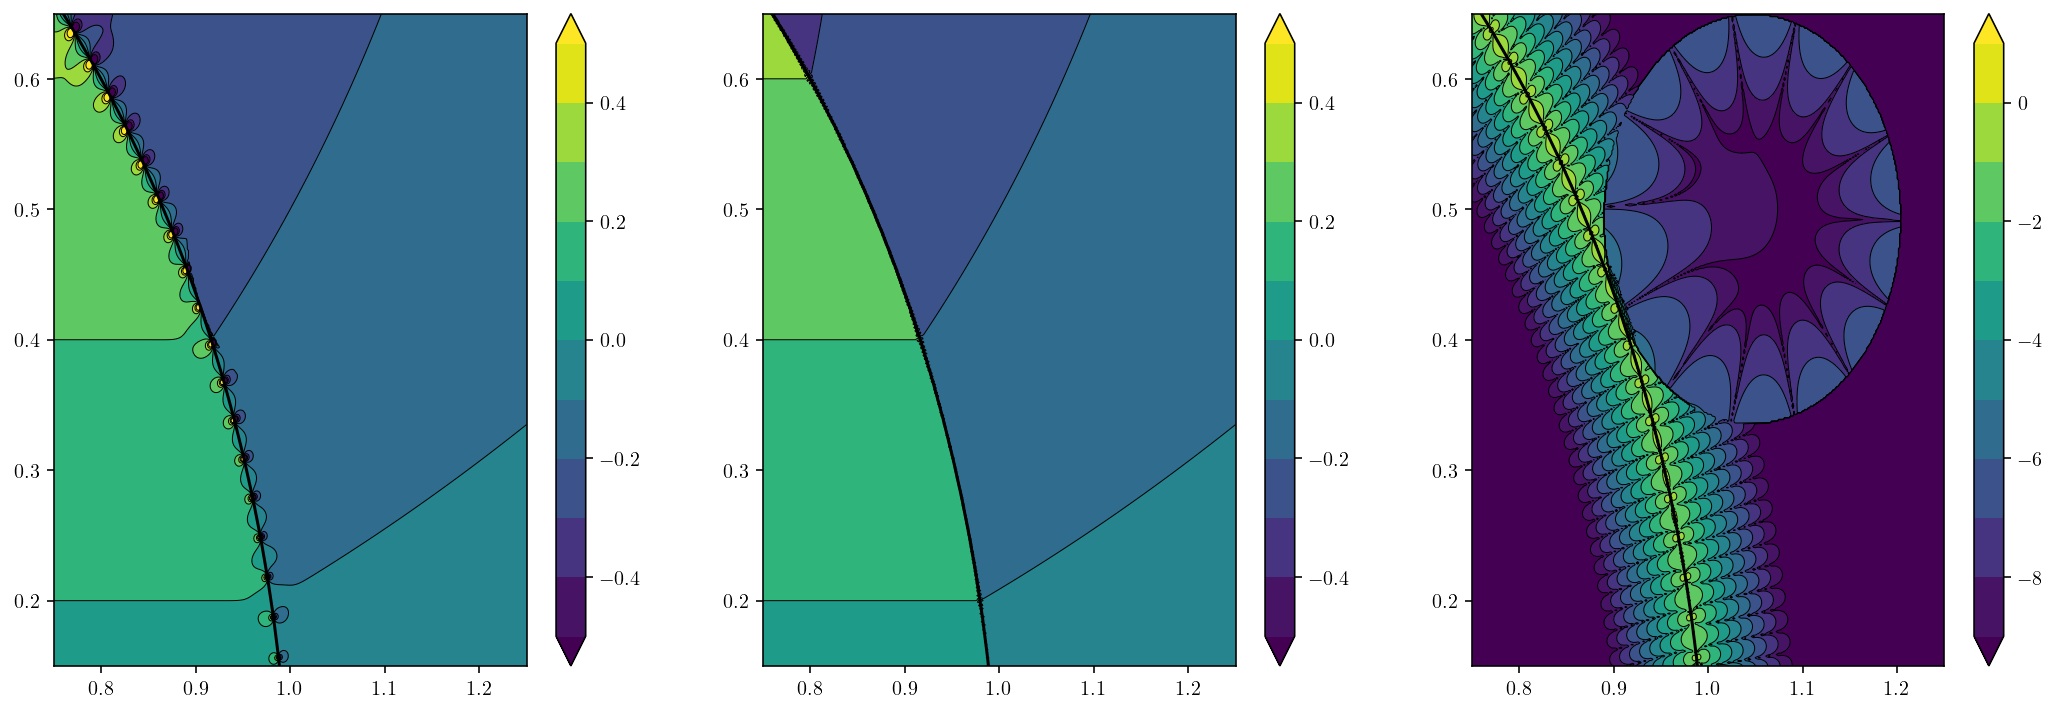

In [87]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
levels = np.linspace(-0.5, 0.5, 11)
cntf = plt.contourf(xs, ys, bie_eval_qbx, levels=levels, extend="both")
plt.contour(xs, ys, bie_eval_qbx, colors='k', linestyles='-', linewidths=0.5, levels=levels, extend="both")
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,2)
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
levels = np.linspace(-0.5, 0.5, 11)
cntf = plt.contourf(xs, ys, bie_eval_high, levels=levels, extend="both")
plt.contour(xs, ys, bie_eval_high, colors='k', linestyles='-', linewidths=0.5, levels=levels, extend="both")
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,3)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_qbx))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
error_levels = np.linspace(-9, 1, 11)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

In [88]:
bie_eval_full_qbx = qbx_interior_eval_matrix(surface, quad_rule, surface[1], obsx, obsy, qbx_center_x, qbx_center_y, qbx_coeffs)

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


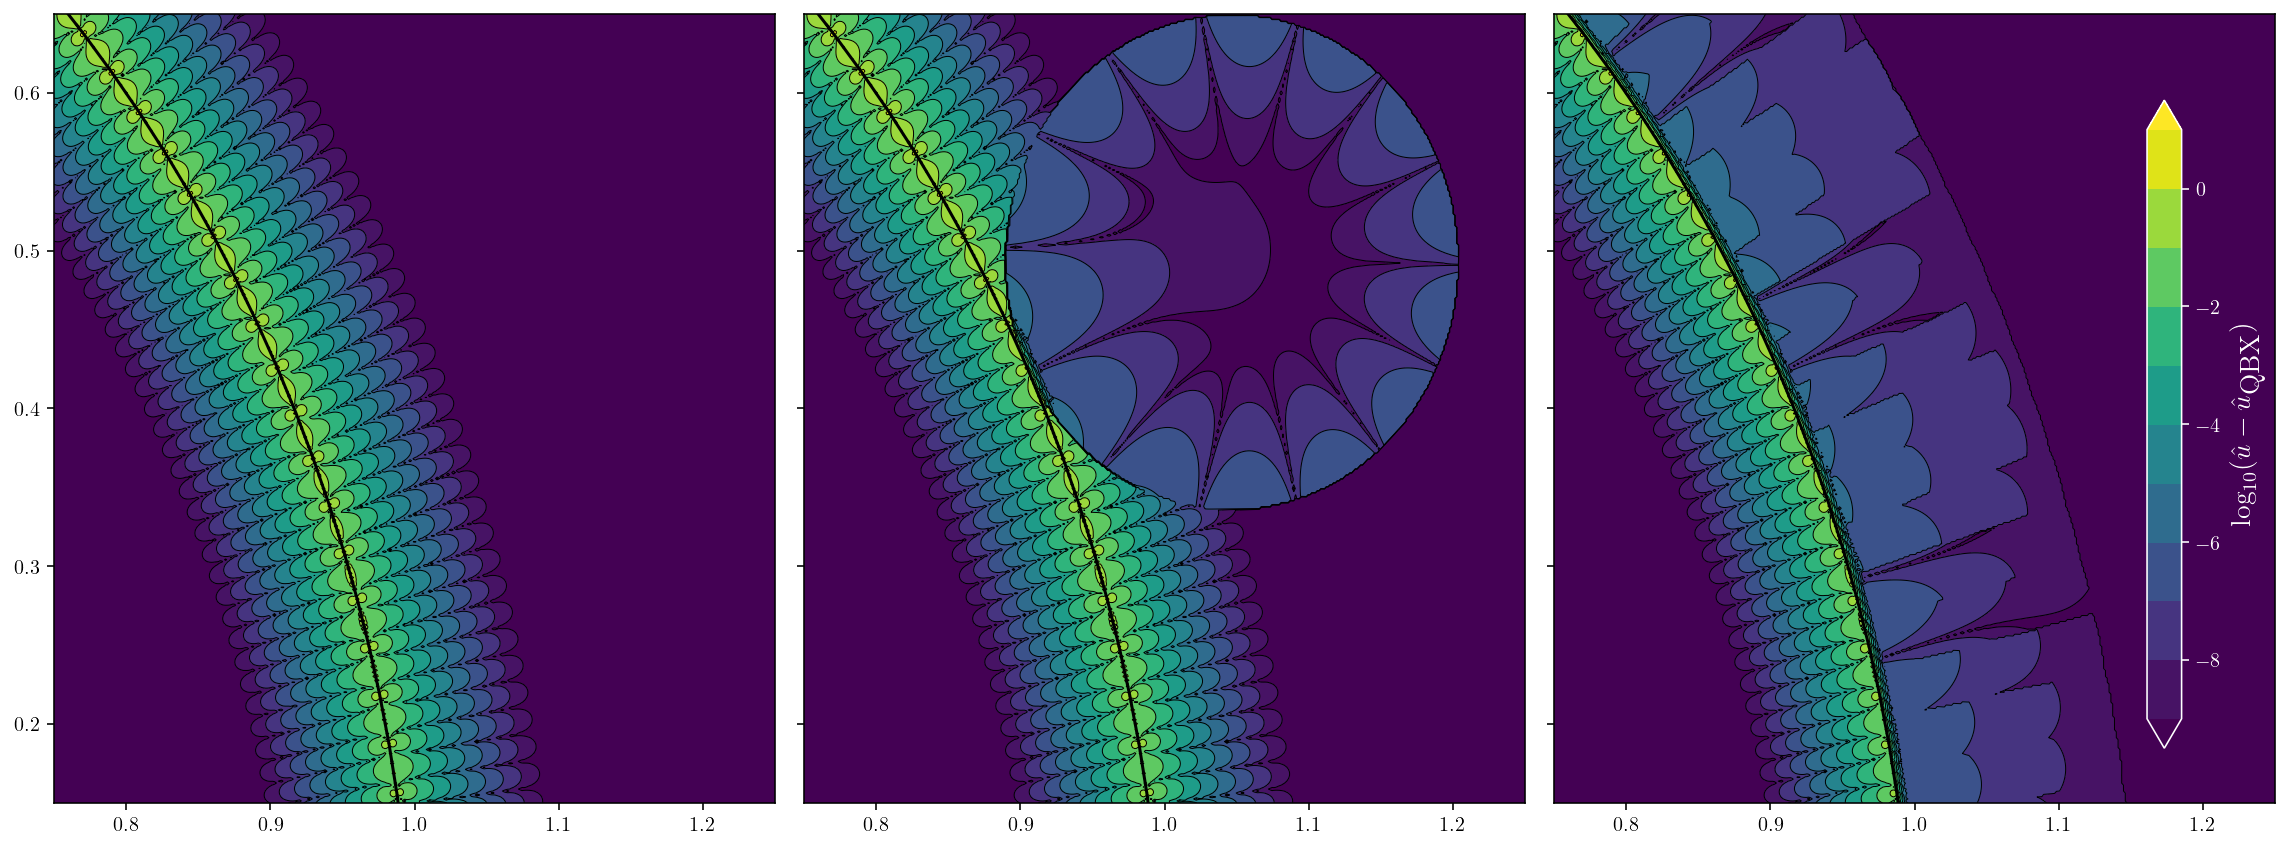

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16,6))
plt.subplot(1,3,1)
logerror = np.log10(np.abs(bie_eval_high - bie_eval))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,2)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_qbx))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(1,3,3)
logerror = np.log10(np.abs(bie_eval_high - bie_eval_full_qbx))
logerror[np.isinf(logerror)]=-17.0
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
cntf = plt.contourf(xs, ys, logerror, levels=error_levels, extend="both")
plt.contour(xs, ys, logerror, colors='k', linestyles='-', linewidths=0.5, levels=error_levels, extend="both")
plt.xlim(zoomx)
plt.ylim(zoomy)
ax = plt.gca()
plt.gca().axes.yaxis.set_ticklabels([])

#fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.935, 0.125, 0.015, 0.75])
cb = fig.colorbar(cntf, cax=cbar_ax)

cb.set_label('$\log_{10}(\hat{u} - \hat{u}_{\\textrm{QBX}})$', color='w', fontsize=14)
cb.ax.yaxis.set_tick_params(color='w')
cb.outline.set_edgecolor('w')
cbytick_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cbytick_obj, color='w')

plt.tight_layout()
plt.savefig('qbx.pdf')
plt.show()

In [22]:
n = 400
qbx_p = 4
quad_rule = trapezoidal_rule(n)
surface = circle(quad_rule[0])

In [199]:
for n in np.arange(100, 1000, 100):
#    n = 400
    qbx_p = 3
    quad_rule = trapezoidal_rule(n)
    surface = circle(quad_rule[0])
    Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult=5.0)
    Qeval_obs = qbx_eval_matrix(surface[0][None,use_idx:use_idx+1], surface[1][None,use_idx:use_idx+1], qbx_center_x[use_idx:use_idx+1], qbx_center_y[use_idx:use_idx+1], qbx_p = qbx_p)
    print(np.real(Qeval_obs.dot(Qexpand[use_idx,:,:]).dot(surface[0])))

[[0.09368344]]
[[-0.3187024]]
[[-0.41644876]]
[[-0.45243415]]
[[-0.46936345]]
[[-0.47864794]]
[[-0.48428701]]
[[-0.48796329]]
[[-0.49048938]]


In [225]:
for n in np.arange(100, 1500, 200):
#    n = 400
    for qbx_p in [15,20]:#np.arange(3, 12, 1):
        #qbx_p = 3
        quad_rule = trapezoidal_rule(n)
        surface = circle(quad_rule[0])
        use_idx = int(0.07 * n)
        Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult=(n / 100))
        Qeval_obs = qbx_eval_matrix(surface[0][None,use_idx:use_idx+1], surface[1][None,use_idx:use_idx+1], qbx_center_x[use_idx:use_idx+1], qbx_center_y[use_idx:use_idx+1], qbx_p = qbx_p)
        print(n, qbx_p, np.real(Qeval_obs.dot(Qexpand[use_idx,:,:]).dot(surface[0])))

100 15 [[-2.15202115]]
100 20 [[-2.86830223]]
300 15 [[-0.59594612]]
300 20 [[-0.96584089]]
500 15 [[-0.45271313]]
500 20 [[-0.46309371]]
700 15 [[-0.45241336]]
700 20 [[-0.45242062]]
900 15 [[-0.45241353]]
900 20 [[-0.45241351]]
1100 15 [[-0.45241353]]
1100 20 [[-0.45241353]]
1300 15 [[-0.45241353]]
1300 20 [[-0.45241353]]


In [227]:
for n in [100,200,300]:
#    n = 400
    for qbx_p in [2,3,4,5,6]:#np.arange(3, 12, 1):
        #qbx_p = 3
        quad_rule = trapezoidal_rule(n)
        surface = circle(quad_rule[0])
        use_idx = int(0.07 * n)
        Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult=(n / 100))
        Qeval_obs = qbx_eval_matrix(surface[0][None,use_idx:use_idx+1], surface[1][None,use_idx:use_idx+1], qbx_center_x[use_idx:use_idx+1], qbx_center_y[use_idx:use_idx+1], qbx_p = qbx_p)
        print(n, qbx_p, np.real(Qeval_obs.dot(Qexpand[use_idx,:,:]).dot(surface[0])))

100 2 [[-0.47857435]]
100 3 [[-0.52973892]]
100 4 [[-0.59544934]]
100 5 [[-0.68764523]]
100 6 [[-0.81484806]]
200 2 [[-0.45151995]]
200 3 [[-0.45577353]]
200 4 [[-0.45717255]]
200 5 [[-0.45719678]]
200 6 [[-0.45941801]]
300 2 [[-0.45082211]]
300 3 [[-0.45247708]]
300 4 [[-0.45258131]]
300 5 [[-0.45241834]]
300 6 [[-0.4520465]]


In [299]:
n = 1000
qbx_p = 15
quad_rule = trapezoidal_rule(n)
surface = circle(quad_rule[0])

In [312]:
def surface_self_integral(surface, quad_rule, qbx_p, direction):
    Qexpand, qbx_center_x, qbx_center_y, qbx_r = qbx_expand_matrix(surface, quad_rule, qbx_p = qbx_p, mult=n/100.0, direction = direction)
    Qeval_surface = qbx_eval_matrix(surface[0][None,:], surface[1][None, :], qbx_center_x, qbx_center_y, qbx_p = qbx_p)

    surface_eval_matrix = np.zeros((n, n))
    for L in range(qbx_p):
        term = np.real(Qeval_surface[0,:,L] * Qexpand[:,L,:])
        plt.plot(np.log10(np.abs(term[:,0])))
        plt.show()
        surface_eval_matrix += term
    return surface_eval_matrix

In [307]:
D_ext = surface_self_integral(surface, quad_rule, qbx_p, 1.0)
    
surface2 = surface[0], surface[1], surface[2], surface[3], surface[4]
D_int = surface_self_integral(surface2, quad_rule, qbx_p, -1.0)

Ds_ext = D_ext - 0.5 * np.eye(n)
Ds_int = D_int + 0.5 * np.eye(n)
D = 0.5 * (D_ext + D_int)

0 0.00048477048602428964
1 0.0023544549853409913
2 0.00431586022381617
3 0.00586012590297175
4 0.00685437518150793
5 0.007707747746881808
6 0.008735292415226747
7 0.00868753031494243
8 0.009889709037517912
9 0.010069721016229013
10 0.009301437183108267
11 0.010073894924021047
12 0.011191940634354402
13 0.011976369001397
14 0.013014510012021908
0 0.015915494316600772
1 0.015915494346245694
2 0.01591549443518046
3 0.01591549479091945
4 0.015915496213875696
5 0.015915501905700104
6 0.015915524672996586
7 0.01591561574218504
8 0.015915980018944915
9 0.01591743712597113
10 0.01592326555406101
11 0.015946579266460294
12 0.016039834116022392
13 0.016412853513956438
14 0.01790493110595499


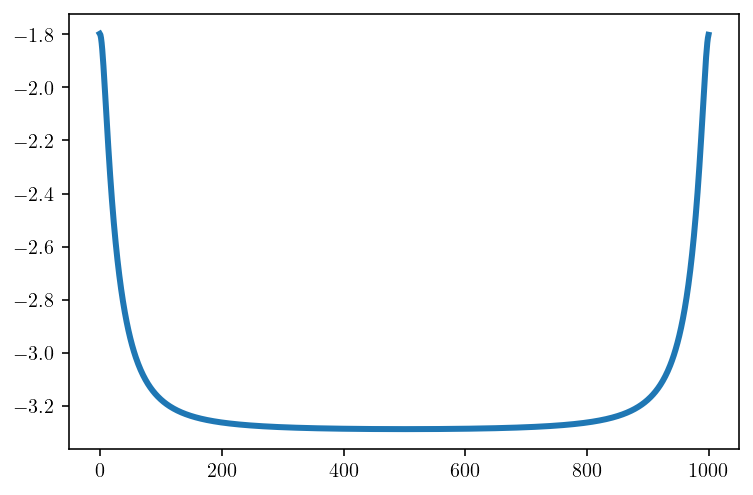

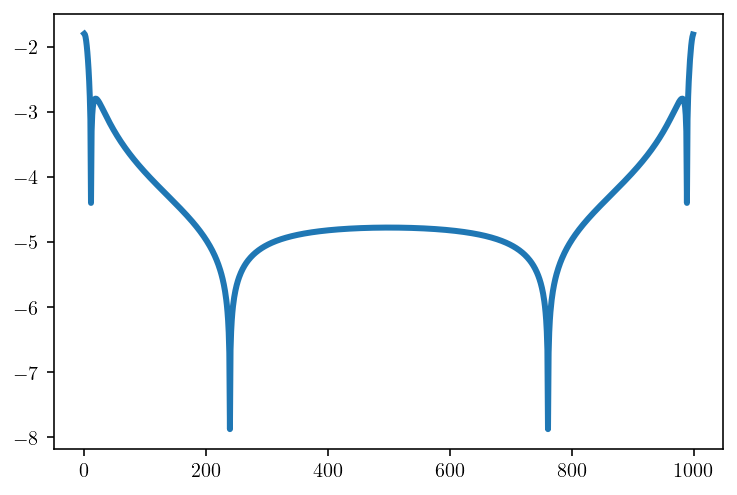

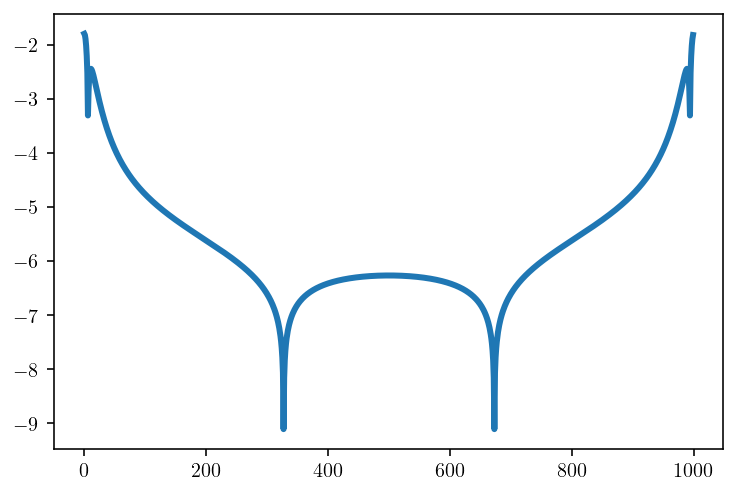

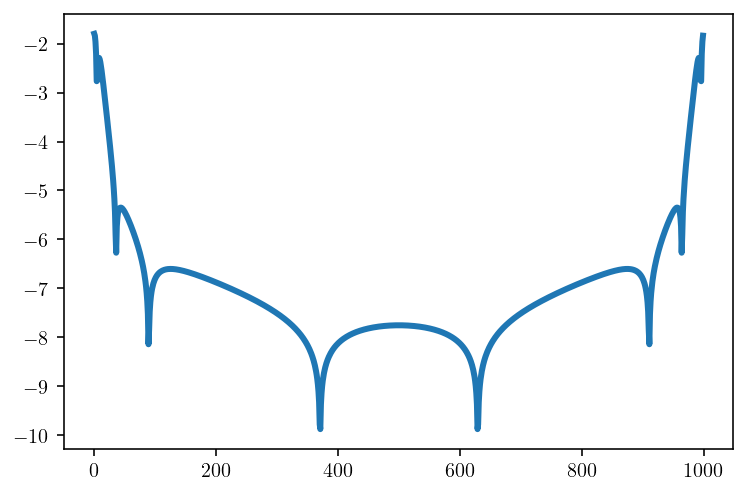

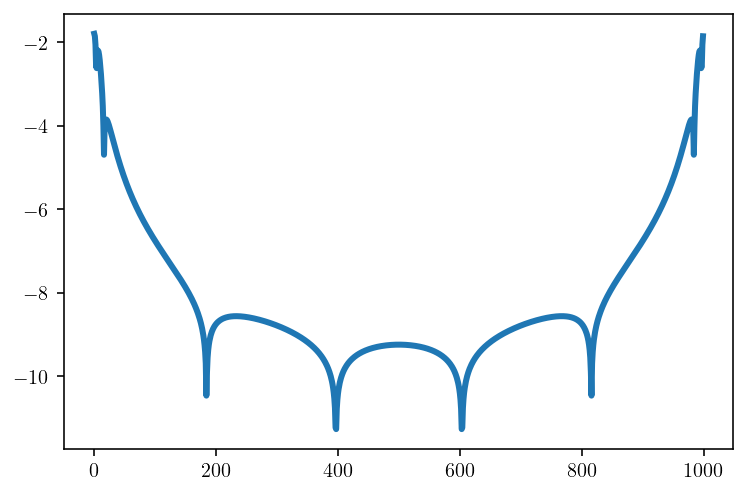

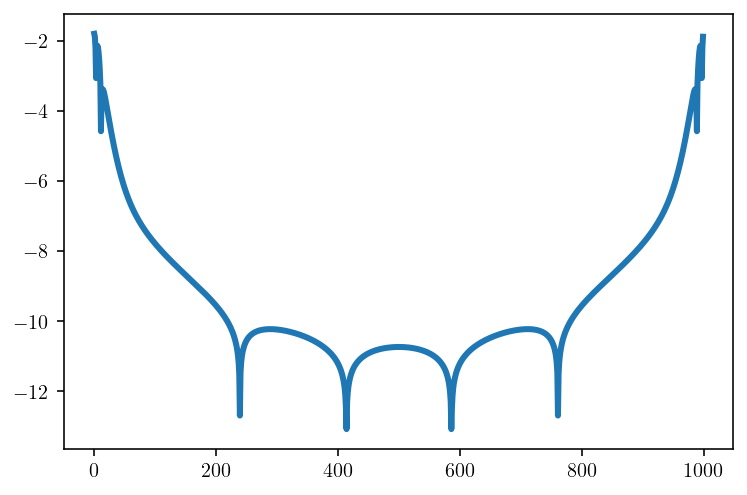

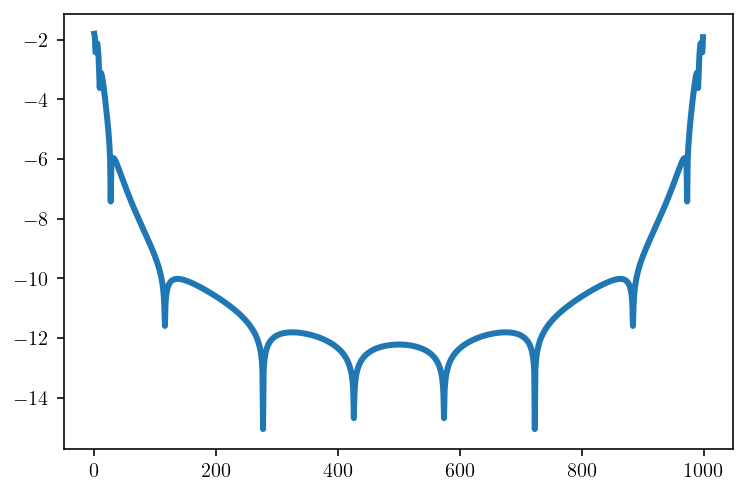

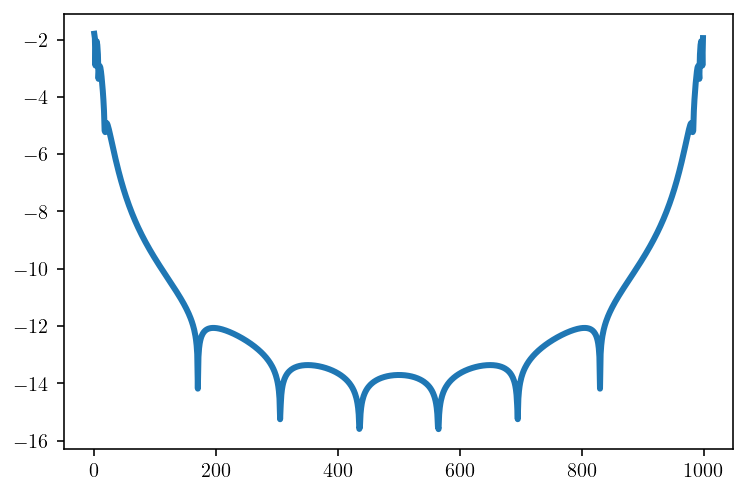

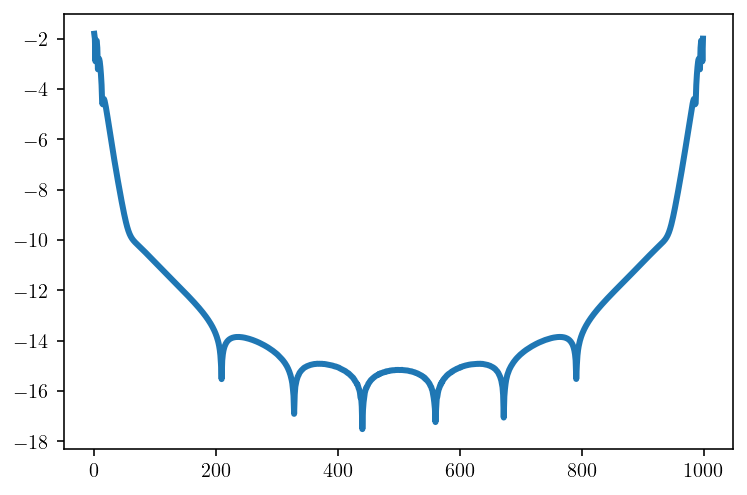

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


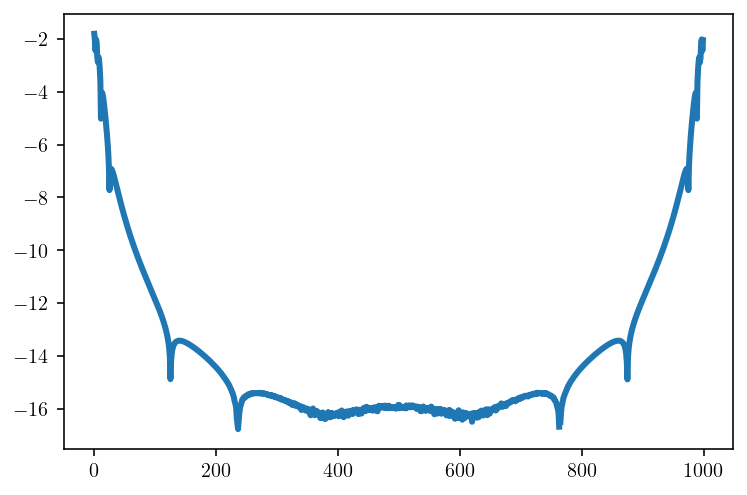

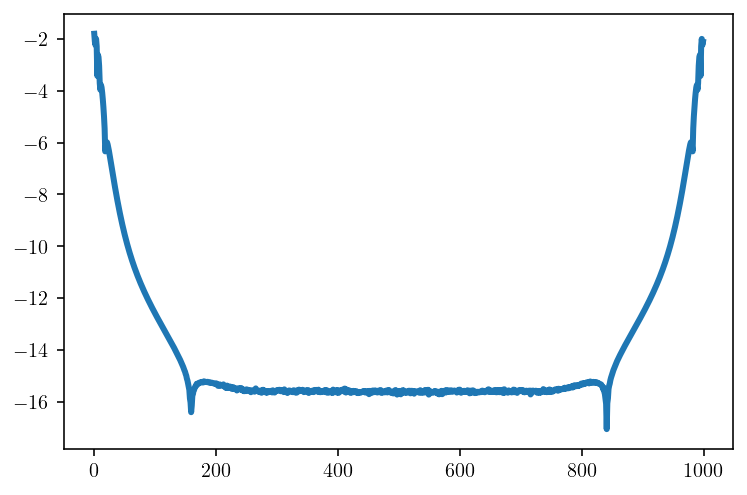

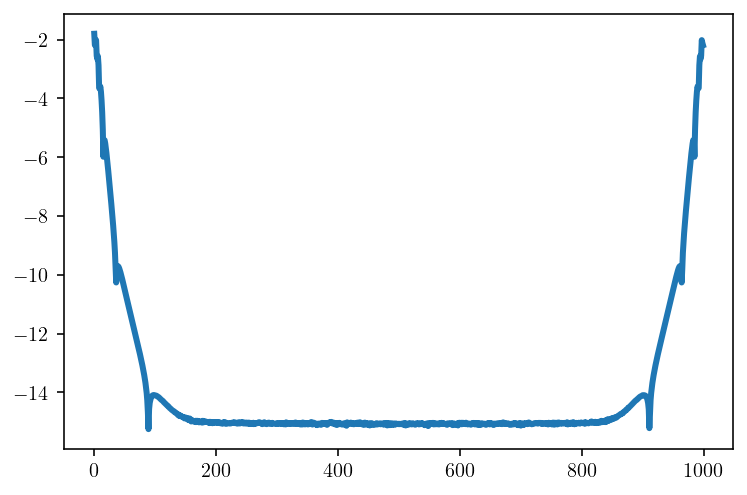

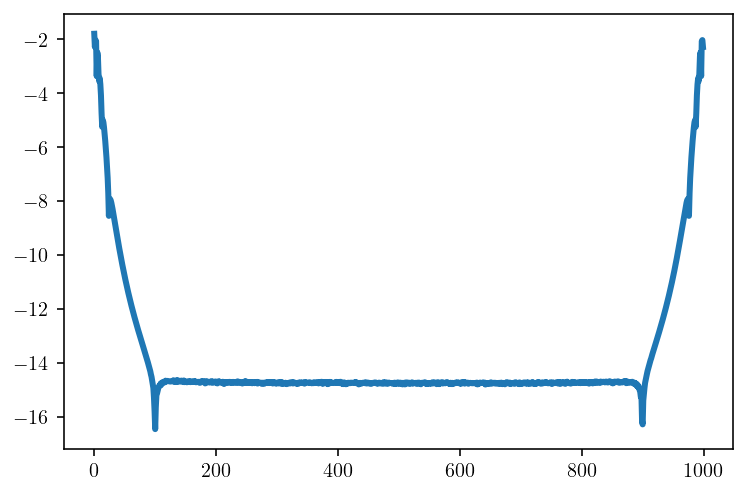

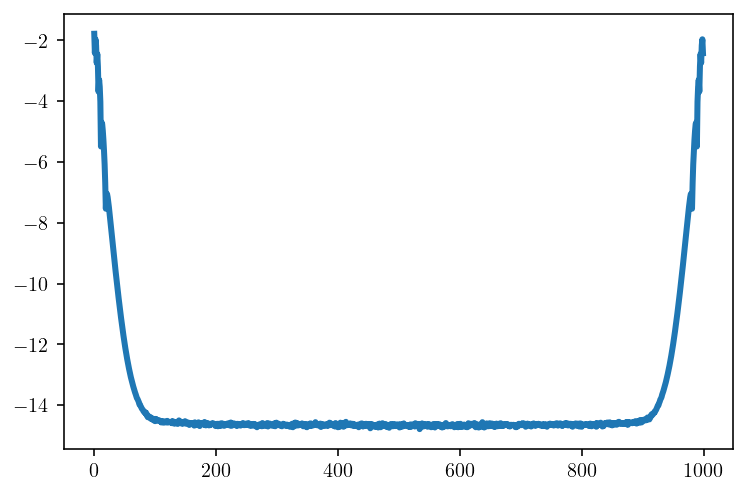

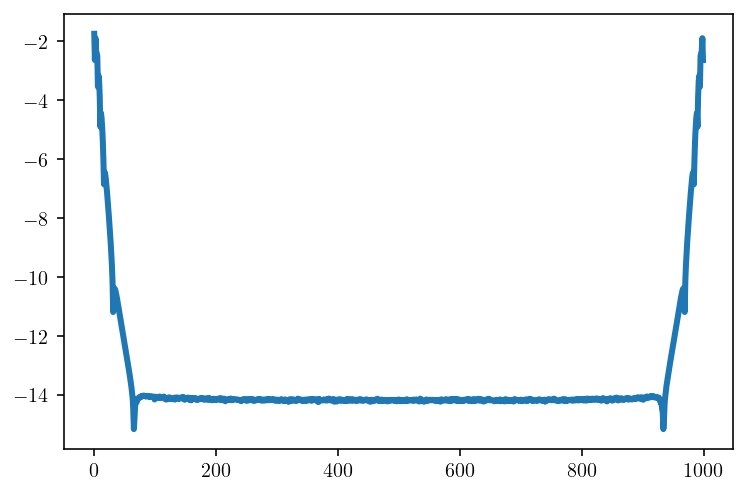

In [314]:
D_ext = surface_self_integral(surface, quad_rule, qbx_p, -1.0)

In [301]:
D_ext[use_idx, use_idx]

-0.24027804919886328

In [302]:
D_ext[0,0], D_int[0,0]

(-0.2360798321528148, 0.24138499712507494)

In [303]:
D[0,0], Ds_ext[0,0], Ds_int[0,0]

(0.0026525824861300673, -0.7360798321528148, 0.741384997125075)

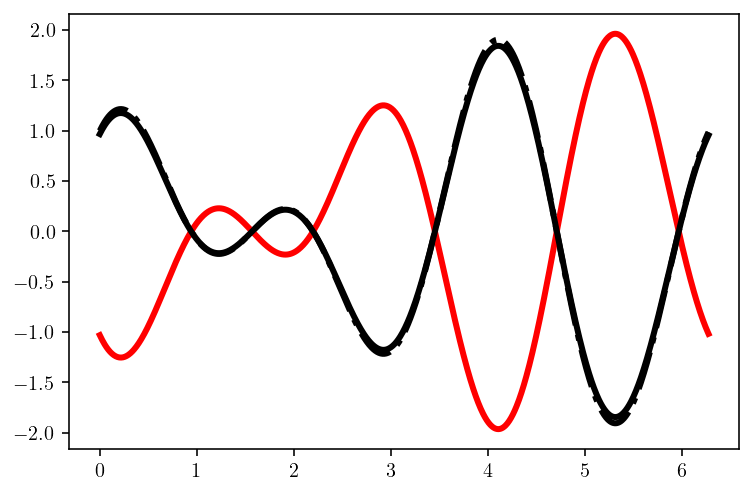

In [304]:
theta = np.pi * (quad_rule[0] + 1)

f = np.cos(3*theta) + np.sin(2*theta)

plt.plot(theta, f, 'k-.')
#plt.plot(theta, np.linalg.inv(D).dot(f), 'b-')
plt.plot(theta, np.linalg.inv(Ds_ext).dot(f), 'r-')
plt.plot(theta, np.linalg.inv(Ds_int).dot(f), 'k-')
plt.show()

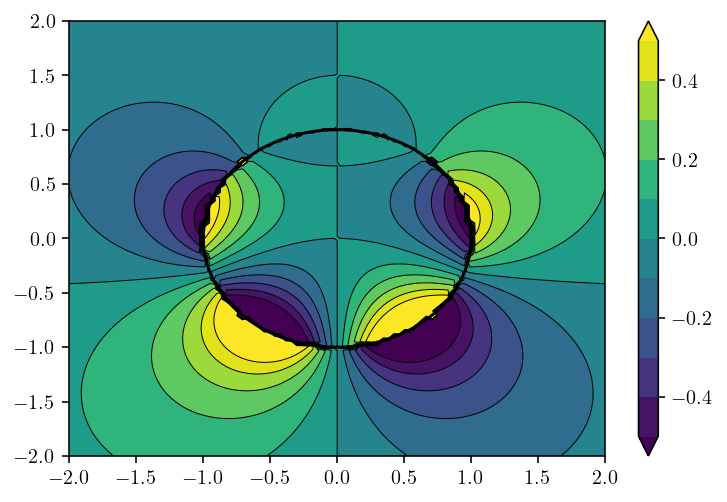

In [298]:
soln = np.linalg.inv(Ds_ext).dot(f)

nobs = 100
xs = np.linspace(-2, 2, nobs)
ys = np.linspace(-2, 2, nobs)
obsx, obsy = np.meshgrid(xs, ys)
interior_matrix = double_layer_matrix(
    surface   = surface,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = quad_rule
)
u = interior_matrix.dot(soln).reshape(obsx.shape)
plt.plot(surface[0], surface[1], 'k-', linewidth=1.5)
levels = np.linspace(-0.5, 0.5, 11)
cntf = plt.contourf(xs, ys, u, levels=levels, extend="both")
plt.contour(xs, ys, u, colors='k', linestyles='-', linewidths=0.5, levels=levels, extend="both")
plt.colorbar(cntf)
plt.show()

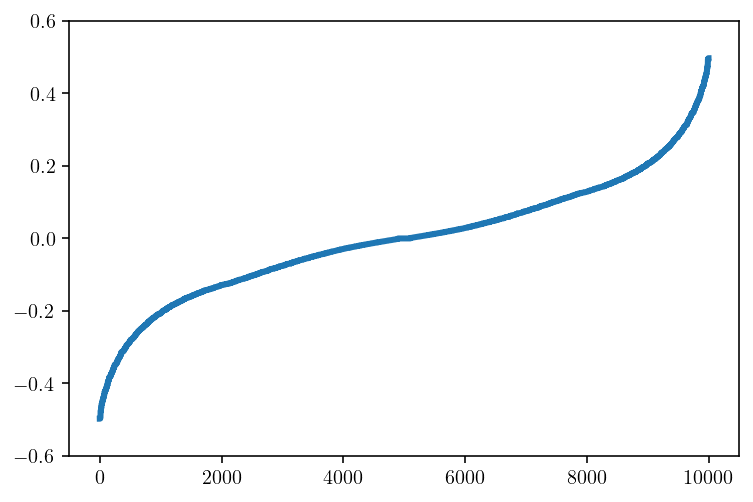

In [287]:
plt.plot(np.sort(u.flatten()))
plt.ylim([-0.6, 0.6])
plt.show()